In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Initialize Spark session
spark = SparkSession.builder.appName("Load Delta Table").getOrCreate()

# Read the Delta table
df_order_spark = spark.read.format("delta").load("abfss://2a82803b-adab-45d6-82fe-95bec0b523fa@onelake.dfs.fabric.microsoft.com/a6a81d45-91d7-40e2-bb4b-fec8b85f0763/Tables/order")

# Convert to Pandas DataFrame
df_order = df_order_spark.toPandas()

# Convert '订单创建时间' to datetime format
df_order['订单创建时间'] = pd.to_datetime(df_order['订单创建时间'])

# Extract year and month and create a new column
df_order['Year-Month'] = df_order['订单创建时间'].dt.to_period('M')

# Aggregate sales amount by month
monthly_sales = df_order.groupby('Year-Month')['商品金额合计'].sum().reset_index()

# Convert 'Year-Month' to datetime format and set as index
monthly_sales['Year-Month'] = pd.to_datetime(monthly_sales['Year-Month'].astype(str), format='%Y-%m')
monthly_sales.set_index('Year-Month', inplace=True)

# Print the last index to confirm it's correct
print("Last index in monthly_sales:", monthly_sales.index[-1])



StatementMeta(, f0a3939f-560d-45e7-944e-54bda72dfbbe, 3, Finished, Available, Finished)

Last index in monthly_sales: 2024-10-01 00:00:00


StatementMeta(, f0a3939f-560d-45e7-944e-54bda72dfbbe, 4, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


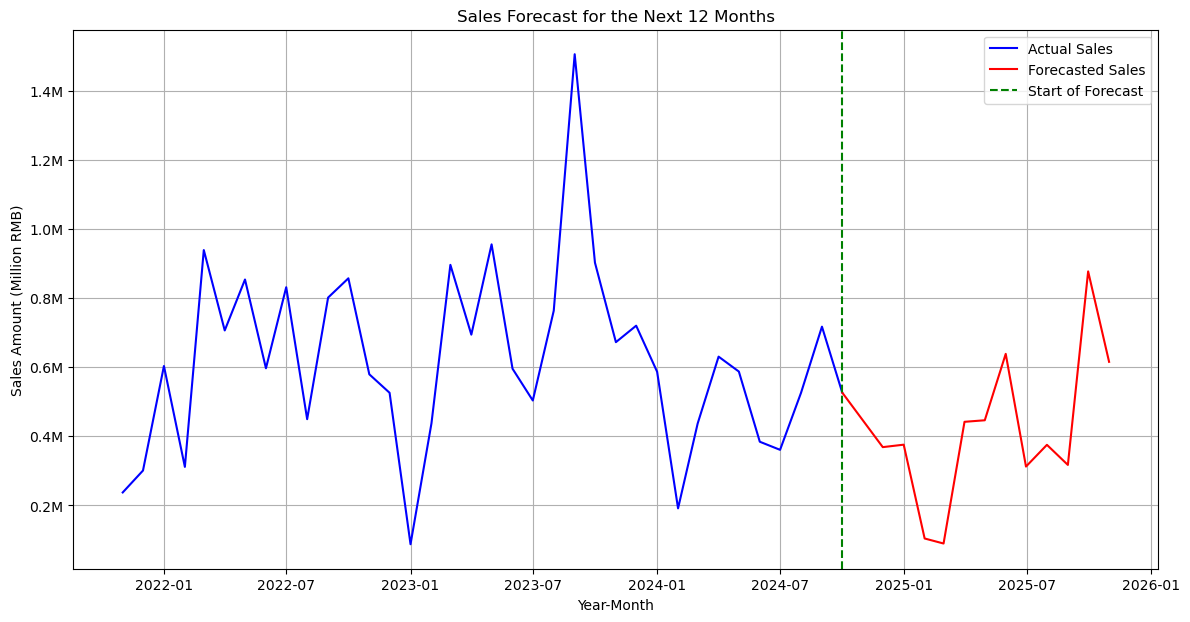

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Predict sales in the following 12 months!

# Use Exponential Smoothing for time series forecasting
model = ExponentialSmoothing(monthly_sales['商品金额合计'], seasonal='add', seasonal_periods=12)
fit_model = model.fit()

# Forecast sales for the next 12 months
future_months = fit_model.forecast(steps=12)

# Adjust future_months to start with the last actual point (both in value and in time)
future_index = pd.date_range(start=monthly_sales.index[-1], periods=13, freq='M')
future_months.index = future_index[1:]

# Manually add the last actual data point to the beginning of future_months to ensure continuity
future_months = pd.concat([pd.Series(monthly_sales['商品金额合计'].iloc[-1], index=[monthly_sales.index[-1]]), future_months])

# Concatenate the actual data and forecasted data to ensure they are connected
full_data = pd.concat([monthly_sales['商品金额合计'], future_months[1:]])  # Exclude the first point to avoid duplication

# Visualize the actual and forecasted sales
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales['商品金额合计'], label='Actual Sales', color='blue')
plt.plot(future_months.index, future_months, label='Forecasted Sales', linestyle='-', color='red')
plt.axvline(x=monthly_sales.index[-1], color='green', linestyle='--', label='Start of Forecast')
plt.title('Sales Forecast for the Next 12 Months')
plt.xlabel('Year-Month')
plt.ylabel('Sales Amount (Million RMB)')

# Convert y-axis to show amounts in millions
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

plt.legend()
plt.grid(True)
plt.show()



In [4]:
from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("Gross Profit Margin Analysis").getOrCreate()

# Read the Delta table
df_goods_spark = spark.read.format("delta").load("abfss://2a82803b-adab-45d6-82fe-95bec0b523fa@onelake.dfs.fabric.microsoft.com/a6a81d45-91d7-40e2-bb4b-fec8b85f0763/Tables/goods")

# Convert to Pandas DataFrame
df_goods = df_goods_spark.toPandas()

# Convert '商品发货时间' to datetime format with error handling
df_goods['商品发货时间'] = pd.to_datetime(df_goods['商品发货时间'], errors='coerce')

# Remove rows where '商品发货时间' is NaT
df_goods = df_goods.dropna(subset=['商品发货时间'])

# Extract year and month and create a new column for grouping
df_goods['Year-Month'] = df_goods['商品发货时间'].dt.to_period('M')

# Calculate monthly total sales and total cost
monthly_summary = df_goods.groupby('Year-Month').apply(
    lambda x: pd.Series({
        'Total Sales': (x['商品单价'] * x['商品数量']).sum(),
        'Total Cost': (x['商品成本价'] * x['商品数量']).sum()
    })
).reset_index()

# Calculate gross profit margin
monthly_summary['Gross Profit Margin (%)'] = ((monthly_summary['Total Sales'] - monthly_summary['Total Cost']) / monthly_summary['Total Sales']) * 100

# Convert 'Year-Month' to string format for display
monthly_summary['Year-Month'] = monthly_summary['Year-Month'].astype(str)

# Display the result
print("Monthly Gross Profit Margin Analysis:")
print(monthly_summary.to_string(index=False))

# Calculate the average gross profit margin
average_gross_profit_margin = monthly_summary['Gross Profit Margin (%)'].mean()

# Display the average gross profit margin
print("\nAverage Gross Profit Margin (%):")
print(f"{average_gross_profit_margin:.2f}%")

# Save the summary as a CSV file for further analysis
monthly_summary.to_csv("monthly_gross_profit_margin.csv", index=False)



StatementMeta(, f0a3939f-560d-45e7-944e-54bda72dfbbe, 5, Finished, Available, Finished)

Monthly Gross Profit Margin Analysis:
Year-Month  Total Sales  Total Cost  Gross Profit Margin (%)
   2021-11    201045.00   150881.00                24.951628
   2021-12    252963.00   234704.60                 7.217814
   2022-01    547959.00   464874.50                15.162540
   2022-02    289286.00   263182.10                 9.023561
   2022-03    829730.00   755781.58                 8.912347
   2022-04    584862.80   498318.73                14.797329
   2022-05    770118.00   587480.15                23.715567
   2022-06    625860.00   545040.16                12.913406
   2022-07    693372.60   452747.16                34.703627
   2022-08    467147.10   219186.10                53.079854
   2022-09    741868.80   623077.90                16.012387
   2022-10    748068.00   730723.70                 2.318546
   2022-11    489744.00   413141.43                15.641349
   2022-12    484787.00   418682.83                13.635714
   2023-01     76762.00    63520.72            

StatementMeta(, f0a3939f-560d-45e7-944e-54bda72dfbbe, 6, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


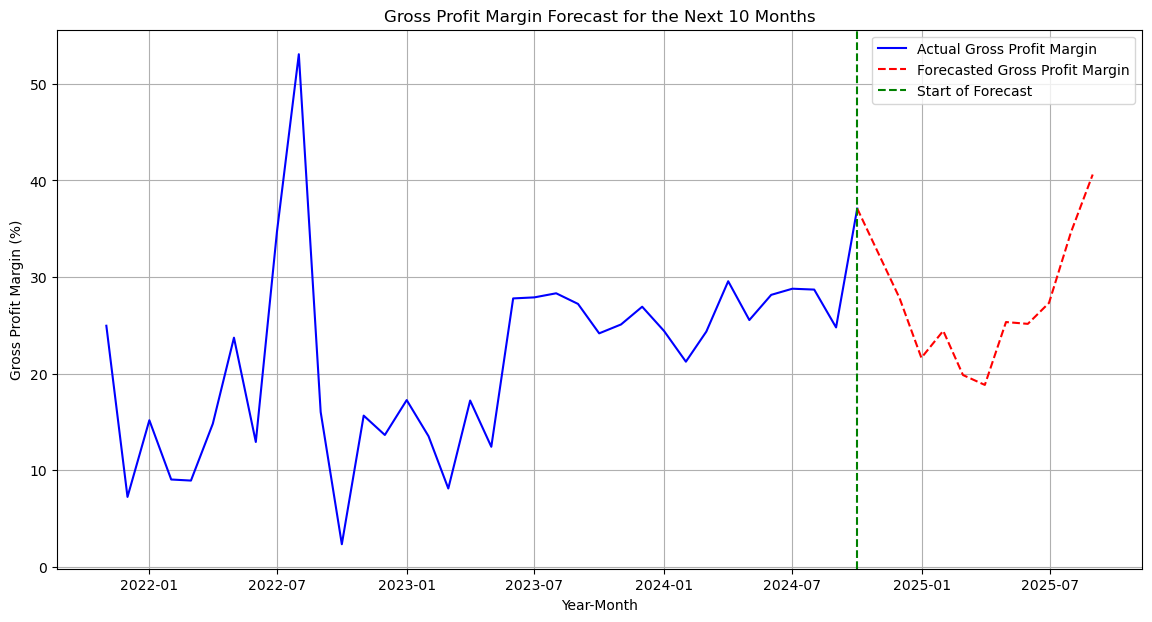


Forecasted Gross Profit Margin for the Next 10 Months:
2024-10-01    37.090332
2024-11-30    27.821375
2024-12-31    21.630050
2025-01-31    24.424730
2025-02-28    19.845116
2025-03-31    18.820848
2025-04-30    25.333921
2025-05-31    25.146829
2025-06-30    27.316159
2025-07-31    34.604481
2025-08-31    40.617278


In [5]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Initialize Spark session
spark = SparkSession.builder.appName("Gross Profit Margin Analysis").getOrCreate()

# Read the Delta table
df_goods_spark = spark.read.format("delta").load("abfss://2a82803b-adab-45d6-82fe-95bec0b523fa@onelake.dfs.fabric.microsoft.com/a6a81d45-91d7-40e2-bb4b-fec8b85f0763/Tables/goods")

# Convert to Pandas DataFrame
df_goods = df_goods_spark.toPandas()

# Convert '商品发货时间' to datetime format with error handling
df_goods['商品发货时间'] = pd.to_datetime(df_goods['商品发货时间'], errors='coerce')

# Remove rows where '商品发货时间' is NaT
df_goods = df_goods.dropna(subset=['商品发货时间'])

# Extract year and month and create a new column for grouping
df_goods['Year-Month'] = df_goods['商品发货时间'].dt.to_period('M')

# Calculate monthly total sales and total cost
monthly_summary = df_goods.groupby('Year-Month').apply(
    lambda x: pd.Series({
        'Total Sales': (x['商品单价'] * x['商品数量']).sum(),
        'Total Cost': (x['商品成本价'] * x['商品数量']).sum()
    })
).reset_index()

# Calculate gross profit margin
monthly_summary['Gross Profit Margin (%)'] = ((monthly_summary['Total Sales'] - monthly_summary['Total Cost']) / monthly_summary['Total Sales']) * 100

# Ensure 'Year-Month' is a datetime index
monthly_summary['Year-Month'] = pd.to_datetime(monthly_summary['Year-Month'].astype(str))
monthly_summary.set_index('Year-Month', inplace=True)

# Use Exponential Smoothing for forecasting
model = ExponentialSmoothing(monthly_summary['Gross Profit Margin (%)'], seasonal='add', seasonal_periods=12)
fit_model = model.fit()

# Forecast for the next 10 months
future_gross_margin = fit_model.forecast(steps=10)

# Create future index for the next 10 months
future_index = pd.date_range(start=monthly_summary.index[-1], periods=11, freq='M')
future_gross_margin.index = future_index[1:]

# Manually add the last actual data point to the beginning of the forecast for continuity
future_gross_margin = pd.concat([pd.Series(monthly_summary['Gross Profit Margin (%)'].iloc[-1], index=[monthly_summary.index[-1]]), future_gross_margin])

# Concatenate actual and forecasted data
full_data = pd.concat([monthly_summary['Gross Profit Margin (%)'], future_gross_margin[1:]])  # Exclude first forecasted point to avoid duplication

# Plot the actual and forecasted gross profit margin
plt.figure(figsize=(14, 7))
plt.plot(monthly_summary.index, monthly_summary['Gross Profit Margin (%)'], label='Actual Gross Profit Margin', color='blue')
plt.plot(future_gross_margin.index, future_gross_margin, label='Forecasted Gross Profit Margin', linestyle='--', color='red')
plt.axvline(x=monthly_summary.index[-1], color='green', linestyle='--', label='Start of Forecast')
plt.title('Gross Profit Margin Forecast for the Next 10 Months')
plt.xlabel('Year-Month')
plt.ylabel('Gross Profit Margin (%)')
plt.legend()
plt.grid(True)
plt.show()

# Print the forecasted gross profit margins
print("\nForecasted Gross Profit Margin for the Next 10 Months:")
print(future_gross_margin.to_string())



In [12]:
# find out Top 200 customers!!
# Group by '收货人/提货人' and aggregate total sales amount
top_customers = df_order.groupby('收货人/提货人')['商品金额合计'].sum().reset_index()

# Sort by '商品金额合计' and get the top 200 customers
top_customers_sorted = top_customers.sort_values(by='商品金额合计', ascending=False).head(200)

# Select the relevant columns
top_customers_sorted = top_customers_sorted[['收货人/提货人', '商品金额合计']]
top_customers_sorted.columns = ['Customer', 'Total Sales Amount']

# Display the result
print(top_customers_sorted.to_string(index=False))




StatementMeta(, f0a3939f-560d-45e7-944e-54bda72dfbbe, 13, Finished, Available, Finished)

     Customer  Total Sales Amount
          李女士            57115.95
          鞠双霞            45436.26
          王女士            45123.14
          张女士            43339.43
          吴八九            36366.21
           胡静            35913.95
          汪光辉            35229.27
          陈女士            33709.52
           宋敏            33387.00
          刘女士            31653.33
   刘绍华（66955）            31147.00
          魏琼林            29086.86
           韩娟            28982.23
           陈静            28606.77
            刘            27022.51
            陈            26747.29
          贾余梅            26443.30
          柳学莲            26108.18
           陈婷            26103.14
          薛唯薇            26064.68
          董熙君            25109.09
          丁亚妮            24538.08
          夏呵呵            23934.69
          顾燕梅            23798.43
           王旌            23638.82
           威力            22678.71
          赵萌萌            22645.04
           李倩            22283.71
            王 

In [19]:
# Finding the favourite categories for Top 200 Customers and their phone number

# Load data
path = 'abfss://2a82803b-adab-45d6-82fe-95bec0b523fa@onelake.dfs.fabric.microsoft.com/a6a81d45-91d7-40e2-bb4b-fec8b85f0763/Tables/goods'
df_order = pd.read_parquet(path)  # Adjust file loading method as necessary

# Find the top 200 customers by total sales amount
top_customers = df_order.groupby('收货人/提货人')['商品单价'].sum().reset_index()
top_customers_sorted = top_customers.sort_values(by='商品单价', ascending=False).head(200)
top_customers_sorted.columns = ['Customer Name', 'Total Sales Amount']

# Filter orders for the top 200 customers
top_customers_orders = df_order[df_order['收货人/提货人'].isin(top_customers_sorted['Customer Name'])]

# Calculate the most preferred product category for each customer
favorite_categories = (
    top_customers_orders.groupby(['收货人/提货人', '商品类目'])['商品单价']
    .sum()
    .reset_index()
    .sort_values(['收货人/提货人', '商品单价'], ascending=[True, False])
)

# Select the top category for each customer, avoiding "Other"
def get_favorite_category(group):
    if group.iloc[0]['商品类目'] == '其他' and len(group) > 1:
        return group.iloc[1]  # Select the second highest if the top is 'Other'
    return group.iloc[0]  # Otherwise, select the top

favorite_categories = favorite_categories.groupby('收货人/提货人').apply(get_favorite_category).reset_index(drop=True)

# Rename columns for display
favorite_categories.columns = ['Customer Name', 'Favorite Category', 'Total Category Sales Amount']

# Display the result
print("Top 200 Customers' Favorite Categories")
print(favorite_categories.to_string(index=False))


StatementMeta(, f0a3939f-560d-45e7-944e-54bda72dfbbe, 20, Finished, Available, Finished)

Top 200 Customers' Favorite Categories
Customer Name Favorite Category  Total Category Sales Amount
Coach Anna转小饶      幼儿早教/少儿英语/数学                      4557.00
      TJJ6752            羽绒/羽毛被                      2199.00
YJD029780转刘志峰      幼儿早教/少儿英语/数学                      4387.00
          丁亚妮                衬衫                      1957.00
      三号仓转饶梦丹      绘本/图画书/少儿动漫书                      9104.00
           于晶                衬衫                      1494.00
           任佳           鱼油/深海鱼油                      1947.00
          任佳佳               低帮鞋                      1297.00
          伍西羽           鱼油/深海鱼油                      1077.00
          何世丹                风衣                      2296.00
          何春梅             卫衣/绒衫                      2054.00
          何青青      绘本/图画书/少儿动漫书                      3135.00
          佘并秀               连衣裙                      2395.00
           傅维               鱼肝油                      1077.00
            刘              女士包袋               

In [14]:
# Convert '订单创建时间' to datetime format
df_order['订单创建时间'] = pd.to_datetime(df_order['订单创建时间'])

# Get the date 3 months ago from the latest date in the dataset
three_months_ago = df_order['订单创建时间'].max() - pd.DateOffset(months=3)

# Filter the DataFrame to only include orders from the last 3 months
recent_orders = df_order[df_order['订单创建时间'] >= three_months_ago]

# Get the unique customer names who have made purchases in the last 3 months
recent_customers = recent_orders['收货人/提货人'].unique()

# Ensure top_customers_sorted column names are in English
top_customers_sorted.columns = ['Customer Name', 'Total Sales Amount']

# Filter the top 200 customers to find those who have not made a purchase in the last 3 months
inactive_customers = top_customers_sorted[~top_customers_sorted['Customer Name'].isin(recent_customers)]

# Get the last purchase date for each customer
last_purchase_date = df_order.groupby('收货人/提货人')['订单创建时间'].max().reset_index()
last_purchase_date.columns = ['Customer Name', 'Last Purchase Date']

# Merge with the inactive customers to include phone numbers and last purchase date
inactive_customers_with_details = pd.merge(
    inactive_customers,
    df_order[['收货人/提货人', '买家手机号']].drop_duplicates().rename(columns={'收货人/提货人': 'Customer Name', '买家手机号': 'Phone Number'}),
    on='Customer Name',
    how='left'
)

inactive_customers_with_details = pd.merge(
    inactive_customers_with_details,
    last_purchase_date,
    on='Customer Name',
    how='left'
)

# Clean the phone number format
inactive_customers_with_details['Phone Number'] = inactive_customers_with_details['Phone Number'].astype(str).str.replace(r'[\t\s]', '', regex=True)
inactive_customers_with_details['Phone Number'] = inactive_customers_with_details['Phone Number'].apply(lambda x: str(x).split('.')[0] if x.replace('.', '').isdigit() else x)

# Mask the middle four digits of the phone number
inactive_customers_with_details['Phone Number'] = inactive_customers_with_details['Phone Number'].apply(
    lambda x: x[:3] + '****' + x[-4:] if len(x) == 11 and x.isdigit() else x
)

# Format 'Last Purchase Date' to only show the date (YYYY-MM-DD)
inactive_customers_with_details['Last Purchase Date'] = inactive_customers_with_details['Last Purchase Date'].dt.strftime('%Y-%m-%d')

# Print the final result
print(inactive_customers_with_details[['Customer Name', 'Phone Number', 'Total Sales Amount', 'Last Purchase Date']].to_string(index=False))




StatementMeta(, f0a3939f-560d-45e7-944e-54bda72dfbbe, 15, Finished, Available, Finished)

Customer Name Phone Number  Total Sales Amount Last Purchase Date
   刘绍华（66955）  159****1817            31147.00         2023-04-29
          董熙君  136****2405            25109.09         2023-12-15
          董熙君         None            25109.09         2023-12-15
          陶美华  137****7445            21187.74         2024-07-03
           徐飞  138****1156            20116.88         2023-12-17
           徐飞         None            20116.88         2023-12-17
           徐飞  159****6288            20116.88         2023-12-17
          张永纬   104***6728            19647.90         2024-06-28
          李娟娟  158****4851            18962.65         2024-06-29
          李娟娟         None            18962.65         2024-06-29
           赵云  156****0958            18939.80         2024-04-29
           赵云  151****8869            18939.80         2024-04-29
           赵云  137****9378            18939.80         2024-04-29
           赵云  137****1054            18939.80         2024-04-29
          